### Offspring Phenotype Model

We start from a simplified form of the Lobster Boys’ equation (eqn. 4), keeping only the genotype and maternal-phenotype terms:

$$
z' = \alpha z + \gamma (m + \varepsilon)
$$

where

- z' = offspring phenotype
- z = genotype-based expectation  
- m = mother’s phenotype  
- $\varepsilon$ = noise  
- $\alpha, \gamma$ = weights on genotype vs. maternal influence  

---

### Reformulation

- Define the **maternal deviation**:


##### $\delta_t$= Phenotype of the mother - Genetic contribution of mother
##### $\delta_t$ = $P_{t-1} - G_{t-1}$

so that the phenotype is the sum of the genetic component of the current generation and maternal deviation from its phenotype:

$$
P = G_t + \delta_t
$$

- We also separate mutation-related noise $\varepsilon_{m}$ from phenotypic-inheritance noise $\varepsilon_{p}$.  
- Thirdly we allow for a predetermined parameter $\gamma$: the 'decay rate'; controls how the signal is 'forgotten' or allowed to decay in the offspring. 
- Finally we define a evolvable 'weight' term $\alpha$: determines how much importance to give each term of the equation

The new formulation becomes:

$$
Z' = (1- \alpha)(G_t + \varepsilon_{m}) + \alpha(\gamma \delta_t + \varepsilon_{p})
$$

---

Cases for gamma:  
- If $\gamma$ = 1: offspring copy mother as faithfully as possible.  
- If $\gamma$ = 0: offspring ignore mother’s phenotype and rely only on long-term genetic information.  
- If 0 < $\gamma$ < 1: maternal effects decay geometrically across generations (e.g. $\gamma^t$ after t generations).  



In [428]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import seaborn as sns
import statistics
import math
import pickle 
import os
import multiprocessing as mp
import argparse

In [429]:
def w(z_combined):
    return (np.exp(-z_combined**2 /(100))) 

def z_dist(z1, env_opt):
    x0 = env_opt
    return ((np.sqrt((x0 - z1)**2 )))

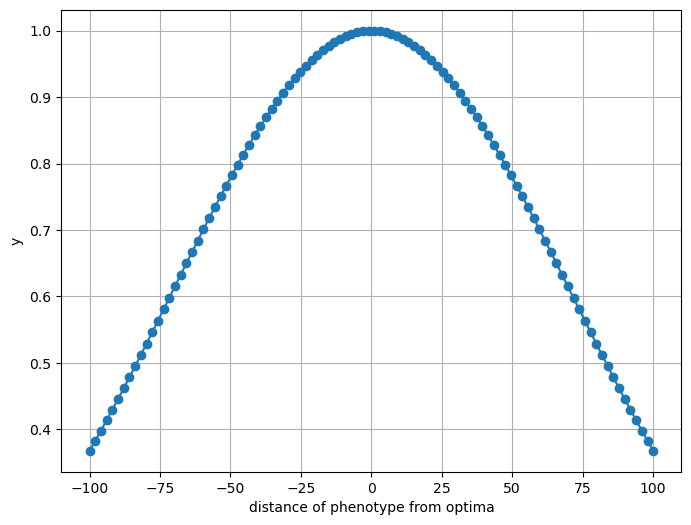

In [3]:
#
z_combined = np.linspace(-100,100,100)
y=np.exp(-z_combined**2 /(10000))

# Plot staying probability vs equilibrium gamma
plt.figure(figsize=(8,6))
plt.plot(z_combined, y, '-o')
plt.xlabel('distance of phenotype from optima')
plt.ylabel('y')
plt.grid(True)
plt.show()

### Properties of the model in 1 D

In [472]:
# Define states
states = ["Dry", "Wet"]

sp =0.99#staying probability

# Transition probability matrix
Transition_probs = np.array([
    [sp, (1-sp)],  # From Dry
    [(1-sp), sp]   # From Wet
])


# Simulate environment over time
n_gen =  2500

#baseline maternal effect
population_size= 1000

env_sequence = []
current_state = 0 

Env = np.array([
    -15,  
    8  
 ])


In [473]:

z_a_t= np.random.uniform(low=0.1, high=0.1, size=population_size) 

P = np.random.uniform(low=-1, high=1, size=population_size)


In [474]:
##define all sigmas
sigma_mut=0.1
sigma_mat = 0.01
sigma_alpha= 0.001

gamma=0.2

alpha = np.random.uniform(low=0, high=1, size=population_size)
#alpha = np.random.normal(0.1, 0.3, size=population_size)

In [475]:
epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
epsilon_alpha= np.random.normal(0, sigma_alpha, size=population_size)

In [476]:


#Initial values for maternal deviation and offspring phenotype
delta = P - (z_a_t)

z_a_t_mut = z_a_t + epsilon_m  # genertic
    
 # maternal effect plus inheiritence error
delta_error = (gamma*delta) + epsilon_p

alpha_error = alpha + epsilon_alpha  # evolving alpha


P = (1-alpha_error)*(z_a_t_mut) + (alpha_error) *(delta_error)



In [477]:

results_df = pd.DataFrame()
optimum_A_over_time =[]
# Initialize environment and population
population_size = 1000
env_sequence = []

# Loop through generations
for t in range(1, n_gen + 1):
    env_sequence.append(states[current_state])  # Log current environment
    current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
    current_env = Env[current_state]  # Optimum values (e.g., for trait A)
    optimum_A_over_time.append(current_env)


    # Transform phenotype with rP_espect to environment
    P_com = z_dist(P, current_env)

    # Calculate fitness
    fitness = w(P_com)
    relative_fitness = fitness / fitness.mean()
    
    # Create generation DataFrame
    df = pd.DataFrame({
        'gen_plus_mut': z_a_t_mut,
        'Phenotype': P,
        'maternal_deviation_werror': delta_error,
        'alpha_w_error': alpha_error,
        'fitness': fitness,
        'relative_fitness': relative_fitness})

    gen_stats = {
    'Generation': t,
    'Environment': current_env,
    'Mean_fitness': df['fitness'].mean(),
    'Var_fitness': df['fitness'].var(),
    'Mean_phenotype': df['Phenotype'].mean(),
    'Std_phenotype': df['Phenotype'].std(),
        
    # New columns statsdelta_error
     
    'Mean_gen_plus_mut': df['gen_plus_mut'].mean(),
    'Std_gen_plus_mut': df['gen_plus_mut'].std(),
    'Mean_maternal_deviation_werror': df['maternal_deviation_werror'].mean(),
    'Std_maternal_deviation_werror': df['maternal_deviation_werror'].std(),
    'Mean_alpha_werror': df['alpha_w_error'].mean(),
    'Std_alpha_werror': df['alpha_w_error'].std()}
    

    # Append row to RESULTS_DF
    results_df = pd.concat([results_df, pd.DataFrame([gen_stats])], ignore_index=True) #wrap it in a list []
    #is because pd.DataFrame() expects an iterable (like a list) of rows/dictionaries to create a DataFrame

    # Sample next generation (with fitness-proportional reproduction)
    sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)

    
    # Update population for next generation
    z_a_t_mut = sampled_df['gen_plus_mut'].values # the inheirited genetic component inheirits the mutation
    P = sampled_df['Phenotype'].values
    alpha_error = sampled_df['alpha_w_error'].values

    

    #Sample variances
    epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
    epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
    epsilon_alpha= np.random.normal(0, sigma_alpha, size=population_size)
    
    # Compute maternal effect (kept constant across generations)
    delta =  P - z_a_t_mut
     
    z_a_t_mut = z_a_t_mut + epsilon_m  # genertic

    delta_error = (gamma * delta ) + epsilon_p
    
    alpha_error = alpha_error + epsilon_alpha  # evolving alpha
    alpha_error = np.clip(alpha_error, 0,1)
    
    #rint(alpha_error)
    #PHENOTYPE
    P = (1-alpha_error)*(z_a_t_mut) + (alpha_error) * (delta_error)


In [478]:
results_df.iloc[0:10,:]

,Generation,Environment,Mean_fitness,Var_fitness,Mean_phenotype,Std_phenotype,Mean_gen_plus_mut,Std_gen_plus_mut,Mean_maternal_deviation_werror,Std_maternal_deviation_werror,Mean_alpha_werror,Std_alpha_werror
0,1,-15,0.103995,0.000008,0.045615,0.090489,0.104083,0.097221,-0.017313,0.116133,0.497633,0.279553
1,2,-15,0.104052,0.000007,0.043613,0.082432,0.099468,0.131593,-0.011918,0.020503,0.505279,0.278991
2,3,-15,0.104145,0.000009,0.040952,0.096610,0.090936,0.163406,-0.011104,0.019806,0.503098,0.269681
3,4,-15,0.104148,0.000012,0.041207,0.111517,0.089302,0.190929,-0.010198,0.023468,0.505153,0.268081
4,5,-15,0.104151,0.000014,0.041400,0.122353,0.087196,0.216945,-0.009333,0.026779,0.508591,0.265878
5,6,-15,0.104281,0.000016,0.037418,0.127401,0.081196,0.233599,-0.009333,0.029529,0.501068,0.270516
6,7,-15,0.104574,0.000017,0.028174,0.131292,0.068765,0.251332,-0.008387,0.034350,0.506615,0.271263
7,8,-15,0.104655,0.000020,0.026025,0.143974,0.061375,0.273979,-0.008622,0.036176,0.501786,0.271521
8,9,-15,0.104719,0.000021,0.024015,0.145295,0.051705,0.292144,-0.006365,0.040415,0.511084,0.272108
9,10,-15,0.104815,0.000023,0.021245,0.153158,0.039644,0.303220,-0.004215,0.042068,0.508396,0.267344


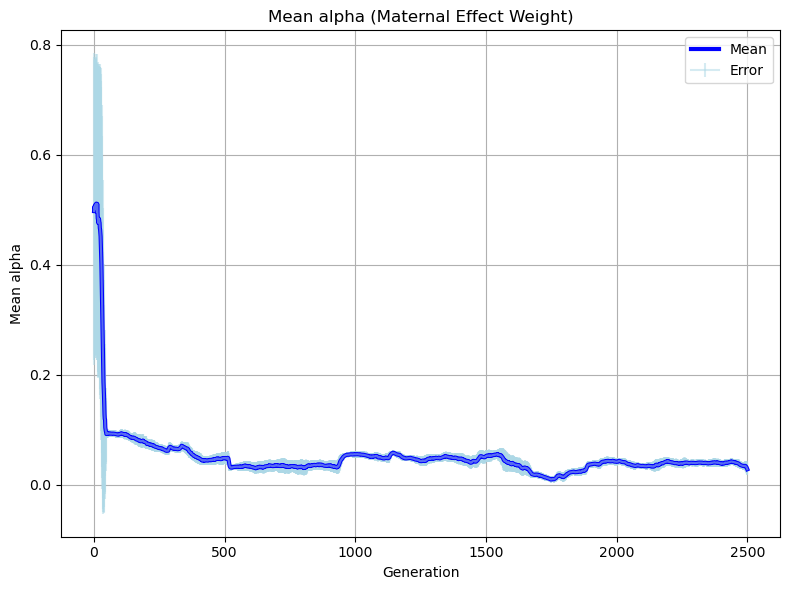

In [479]:
generations = results_df['Generation']

plt.figure(figsize=(8, 6))
plt.errorbar(generations, results_df['Mean_alpha_werror'], yerr=results_df['Std_alpha_werror'], 
             color='lightblue', alpha=0.5, label='Error')
plt.plot(generations, results_df['Mean_alpha_werror'], color='blue', linewidth=3, label='Mean')

plt.title('Mean alpha (Maternal Effect Weight)')
plt.xlabel('Generation')
plt.ylabel('Mean alpha')
plt.grid(True)
plt.legend()
#plt.ylim(0,1)
plt.tight_layout()
plt.show()

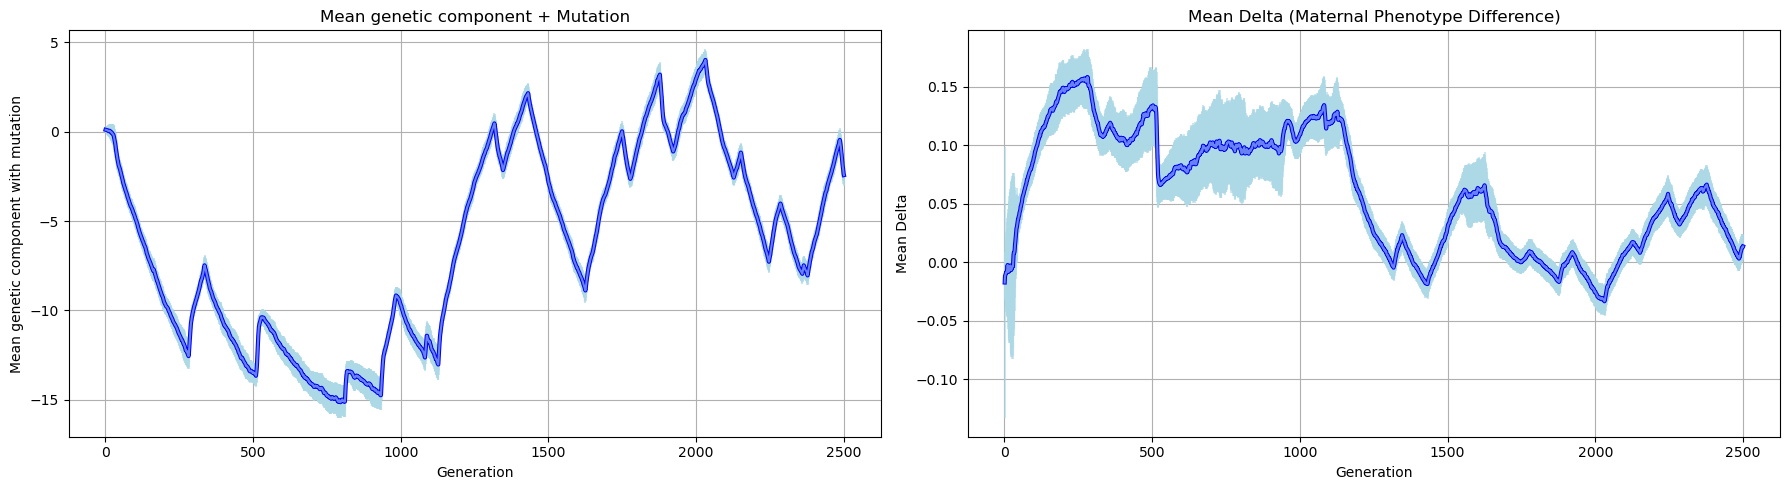

In [480]:

generations = results_df['Generation']

fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

# Plot 1: Mean Gamma
axs[0].errorbar(generations, results_df['Mean_gen_plus_mut'], yerr=results_df['Std_gen_plus_mut'], alpha=0.6, color='lightblue')
axs[0].plot(generations, results_df['Mean_gen_plus_mut'], color='blue', linewidth=3)
axs[0].set_title('Mean genetic component + Mutation')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean genetic component with mutation')
#axs[0].set_ylim(-2, 2)
axs[0].grid(True)

# Plot 3: Mean Delta
axs[1].errorbar(generations, results_df['Mean_maternal_deviation_werror'], yerr=results_df['Std_maternal_deviation_werror'], alpha=0.6, color='lightblue')
axs[1].plot(generations, results_df['Mean_maternal_deviation_werror'], color='blue', linewidth=3)
axs[1].set_title('Mean Delta (Maternal Phenotype Difference)')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Delta')
#axs[1].set_ylim(-0.25, 0.25)
axs[1].grid(True)


plt.tight_layout()
plt.show()


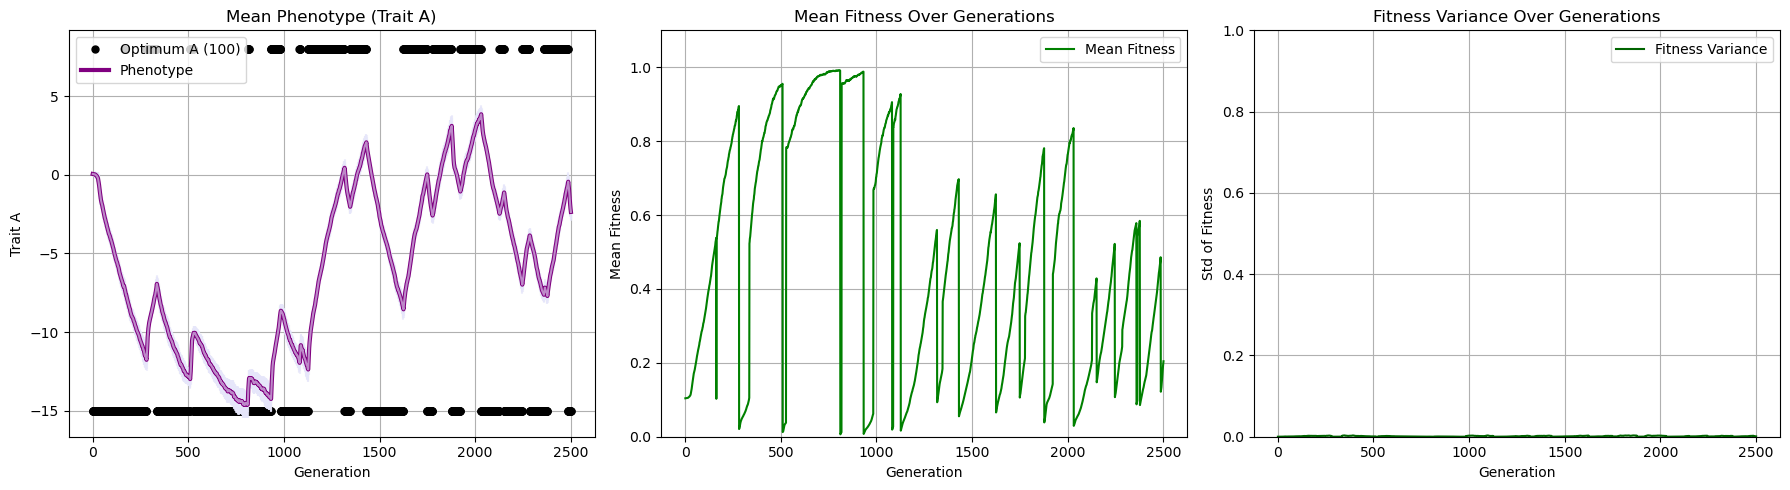

In [481]:
generations = results_df['Generation']

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Phenotype mean
axs[0].plot(optimum_A_over_time, linestyle='None', marker='o', markersize=5, color='black', label='Optimum A (100)')
axs[0].errorbar(generations,results_df['Mean_phenotype'], yerr=results_df['Std_phenotype'], 
                   color='lavender', alpha=0.6 ) 
axs[0].plot(generations, results_df['Mean_phenotype'], label='Phenotype', color='purple', linewidth=3)
axs[0].set_title('Mean Phenotype (Trait A)')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Trait A')
#axs[0].set_ylim(-10,10)
#axs[0].set_xlim(840,860)
axs[0].grid(True)
axs[0].legend()

# Mean fitness
axs[1].plot(generations, results_df['Mean_fitness'], label='Mean Fitness', color='green')
axs[1].set_title('Mean Fitness Over Generations')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Fitness')
#axs[1].set_xlim(220,280)
axs[1].set_ylim(0,1.1)
axs[1].grid(True)
axs[1].legend()

# Variance (Std) of fitness
axs[2].plot(generations, results_df['Var_fitness'], label='Fitness Variance', color='darkgreen')
axs[2].set_title('Fitness Variance Over Generations')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Std of Fitness')
axs[2].grid(True)
axs[2].set_ylim(0,1)
axs[2].legend()

plt.tight_layout()
plt.show()
 

### crappy code

In [410]:
# Define states
states = ["Dry", "Wet"]
n_states = len(states)

sp =1#staying probability

# Transition probability matrix
Transition_probs = np.array([
    [sp, (1-sp)],  # From Dry
    [(1-sp), sp]   # From Wet
])


env_sequence = []
current_state = 0 

Env = np.array([
    -0.9,  
    0.5,  
 ])


In [411]:

gamma_values = np.linspace(0, 1, 100)
equilibrium_alpha_means = []
eqm_gamma_std=[]

# Select 10 indices from 0 to 99 to save trajectories for
selected_indices = np.linspace(1, 99, 10, dtype=int)
selected_gamma_values = gamma_values[selected_indices]

# To store mean gamma trajectories for selected sp values
gamma_trajectories = {g: [] for g in selected_gamma_values}
gamma_trajectories

{np.float64(0.010101010101010102): [],
 np.float64(0.11111111111111112): [],
 np.float64(0.22222222222222224): [],
 np.float64(0.33333333333333337): [],
 np.float64(0.4444444444444445): [],
 np.float64(0.5555555555555556): [],
 np.float64(0.6666666666666667): [],
 np.float64(0.7777777777777778): [],
 np.float64(0.888888888888889): [],
 np.float64(1.0): []}

In [412]:
gamma_trajectories

{np.float64(0.010101010101010102): [],
 np.float64(0.11111111111111112): [],
 np.float64(0.22222222222222224): [],
 np.float64(0.33333333333333337): [],
 np.float64(0.4444444444444445): [],
 np.float64(0.5555555555555556): [],
 np.float64(0.6666666666666667): [],
 np.float64(0.7777777777777778): [],
 np.float64(0.888888888888889): [],
 np.float64(1.0): []}

In [413]:
# Parameters
n_gen = 2500
population_size = 1000
Env = np.array([-0.9, 0.5])

sigma_mut = 0.4
sigma_mat = 0.2
sigma_alpha = 0.01

gamma_values = np.linspace(0, 1, 100)
equilibrium_gamma_means = []
eqm_gamma_std=[]

results = {}


In [414]:
epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
epsilon_alpha= np.random.normal(0, sigma_alpha, size=population_size)

In [415]:

for gamma in gamma_values:
    
        current_state = 0
        current_env = Env[current_state]
        
        # Initial population
        alpha = np.random.uniform(0, 1, population_size)
        z_a_t = np.random.uniform(-0.1, 0.1, population_size)
        epsilon_mut = np.random.normal(0, sigma_mut, size=population_size)
        epsilon_mat = np.random.normal(0, sigma_mat, size=population_size)
        epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
        z_a_t_mut = z_a_t + epsilon_mut
        P = np.random.uniform(-10, 10, size=population_size)
        delta = P - z_a_t
        delta_error = delta + epsilon_mat
        alpha_error = alpha + epsilon_alpha
    
        P = (1 - alpha_error) * z_a_t_mut + alpha_error * gamma * delta_error
    
        mean_alpha_over_time = []  # Initialize
        results_df = pd.DataFrame()
        
        for t in range(1, n_gen + 1):
            current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
            current_env = Env[current_state]
            
            P_com = z_dist(P, current_env)
            fitness = w(P_com)
            relative_fitness = fitness / fitness.mean()
            
            df = pd.DataFrame({
                'gen_plus_mut': z_a_t_mut,
                'Phenotype': P,
                'maternal_deviation_werror': delta_error,
                'alpha_w_error': alpha_error,
                'fitness': fitness,
                'relative_fitness': relative_fitness
            })
    
            gen_stats = {
                'Generation': t,
                'Environment': current_env,
                'Mean_fitness': df['fitness'].mean(),
                'Var_fitness': df['fitness'].var(),
                'Mean_phenotype': df['Phenotype'].mean(),
                'Std_phenotype': df['Phenotype'].std(),
                'Mean_gen_plus_mut': df['gen_plus_mut'].mean(),
                'Std_gen_plus_mut': df['gen_plus_mut'].std(),
                'Mean_maternal_deviation_werror': df['maternal_deviation_werror'].mean(),
                'Std_maternal_deviation_werror': df['maternal_deviation_werror'].std(),
                'Mean_alpha_werror': df['alpha_w_error'].mean(),
                'Std_alpha_werror': df['alpha_w_error'].std()
            }
    
            results_df = pd.concat([results_df, pd.DataFrame([gen_stats])], ignore_index=True)
    
            # Fitness-proportional sampling
            sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)
            z_a_t_mut = sampled_df['gen_plus_mut'].values
            P = sampled_df['Phenotype'].values
            alpha_error = sampled_df['alpha_w_error'].values
    
            # Mutation
            epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
            epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
            epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
            delta = P - z_a_t_mut
            z_a_t_mut = z_a_t_mut + epsilon_m
            delta_error = (gamma*delta) + epsilon_p # delta with decay rate multiplied
            alpha_error = alpha_error + epsilon_alpha
    
            P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error
    
        # Save equilibrium stats
        equilibrium_mean_alpha = np.mean(alpha_error)
        equilibrium_std_alpha = np.std(alpha_error)
        equilibrium_gamma_means.append(equilibrium_mean_alpha)
        eqm_gamma_std.append(equilibrium_std_alpha)
    
        if (gamma, sp) in selected_gamma_values:
            # Save full results_df for this gamma
            results[gamma]= results_df



ValueError: operands could not be broadcast together with shapes (10,) (2,) 

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

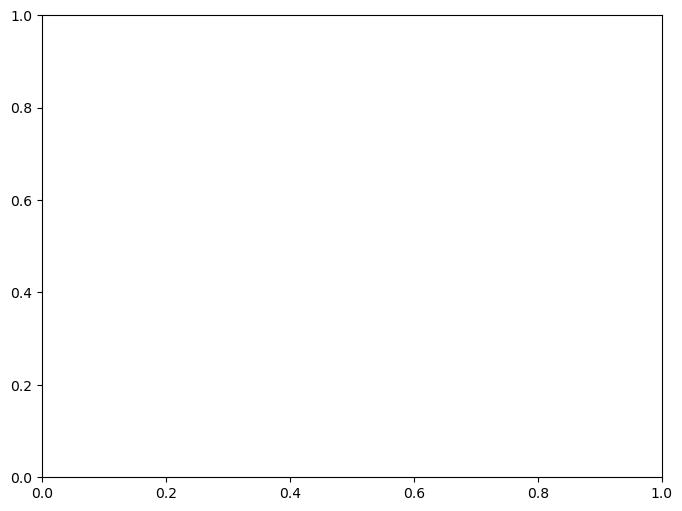

In [73]:
plt.figure(figsize=(8,6))

# Plotting the main line
plt.plot(gamma_values, equilibrium_gamma_means, 'o-', color='b', label=r'$\alpha$')

# Creating the error cloud using fill_between
plt.fill_between(gamma_values, 
                 np.array(equilibrium_gamma_means) - np.array(eqm_gamma_std), 
                 np.array(equilibrium_gamma_means) + np.array(eqm_gamma_std), 
                 color='b', alpha=0.2, label=r'stdev $\alpha$ ')

# Using LaTeX formatting for Greek letters
plt.xlabel(r'$\gamma$ (Decay rate f($\gamma$))')
plt.ylabel(r'$\alpha$ (Equilibrium Mean $\alpha$)')
plt.title(r'Equilibrium $\alpha$ vs Decay Rate $\gamma$')
plt.grid(True)
plt.ylim(0,1.1)
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

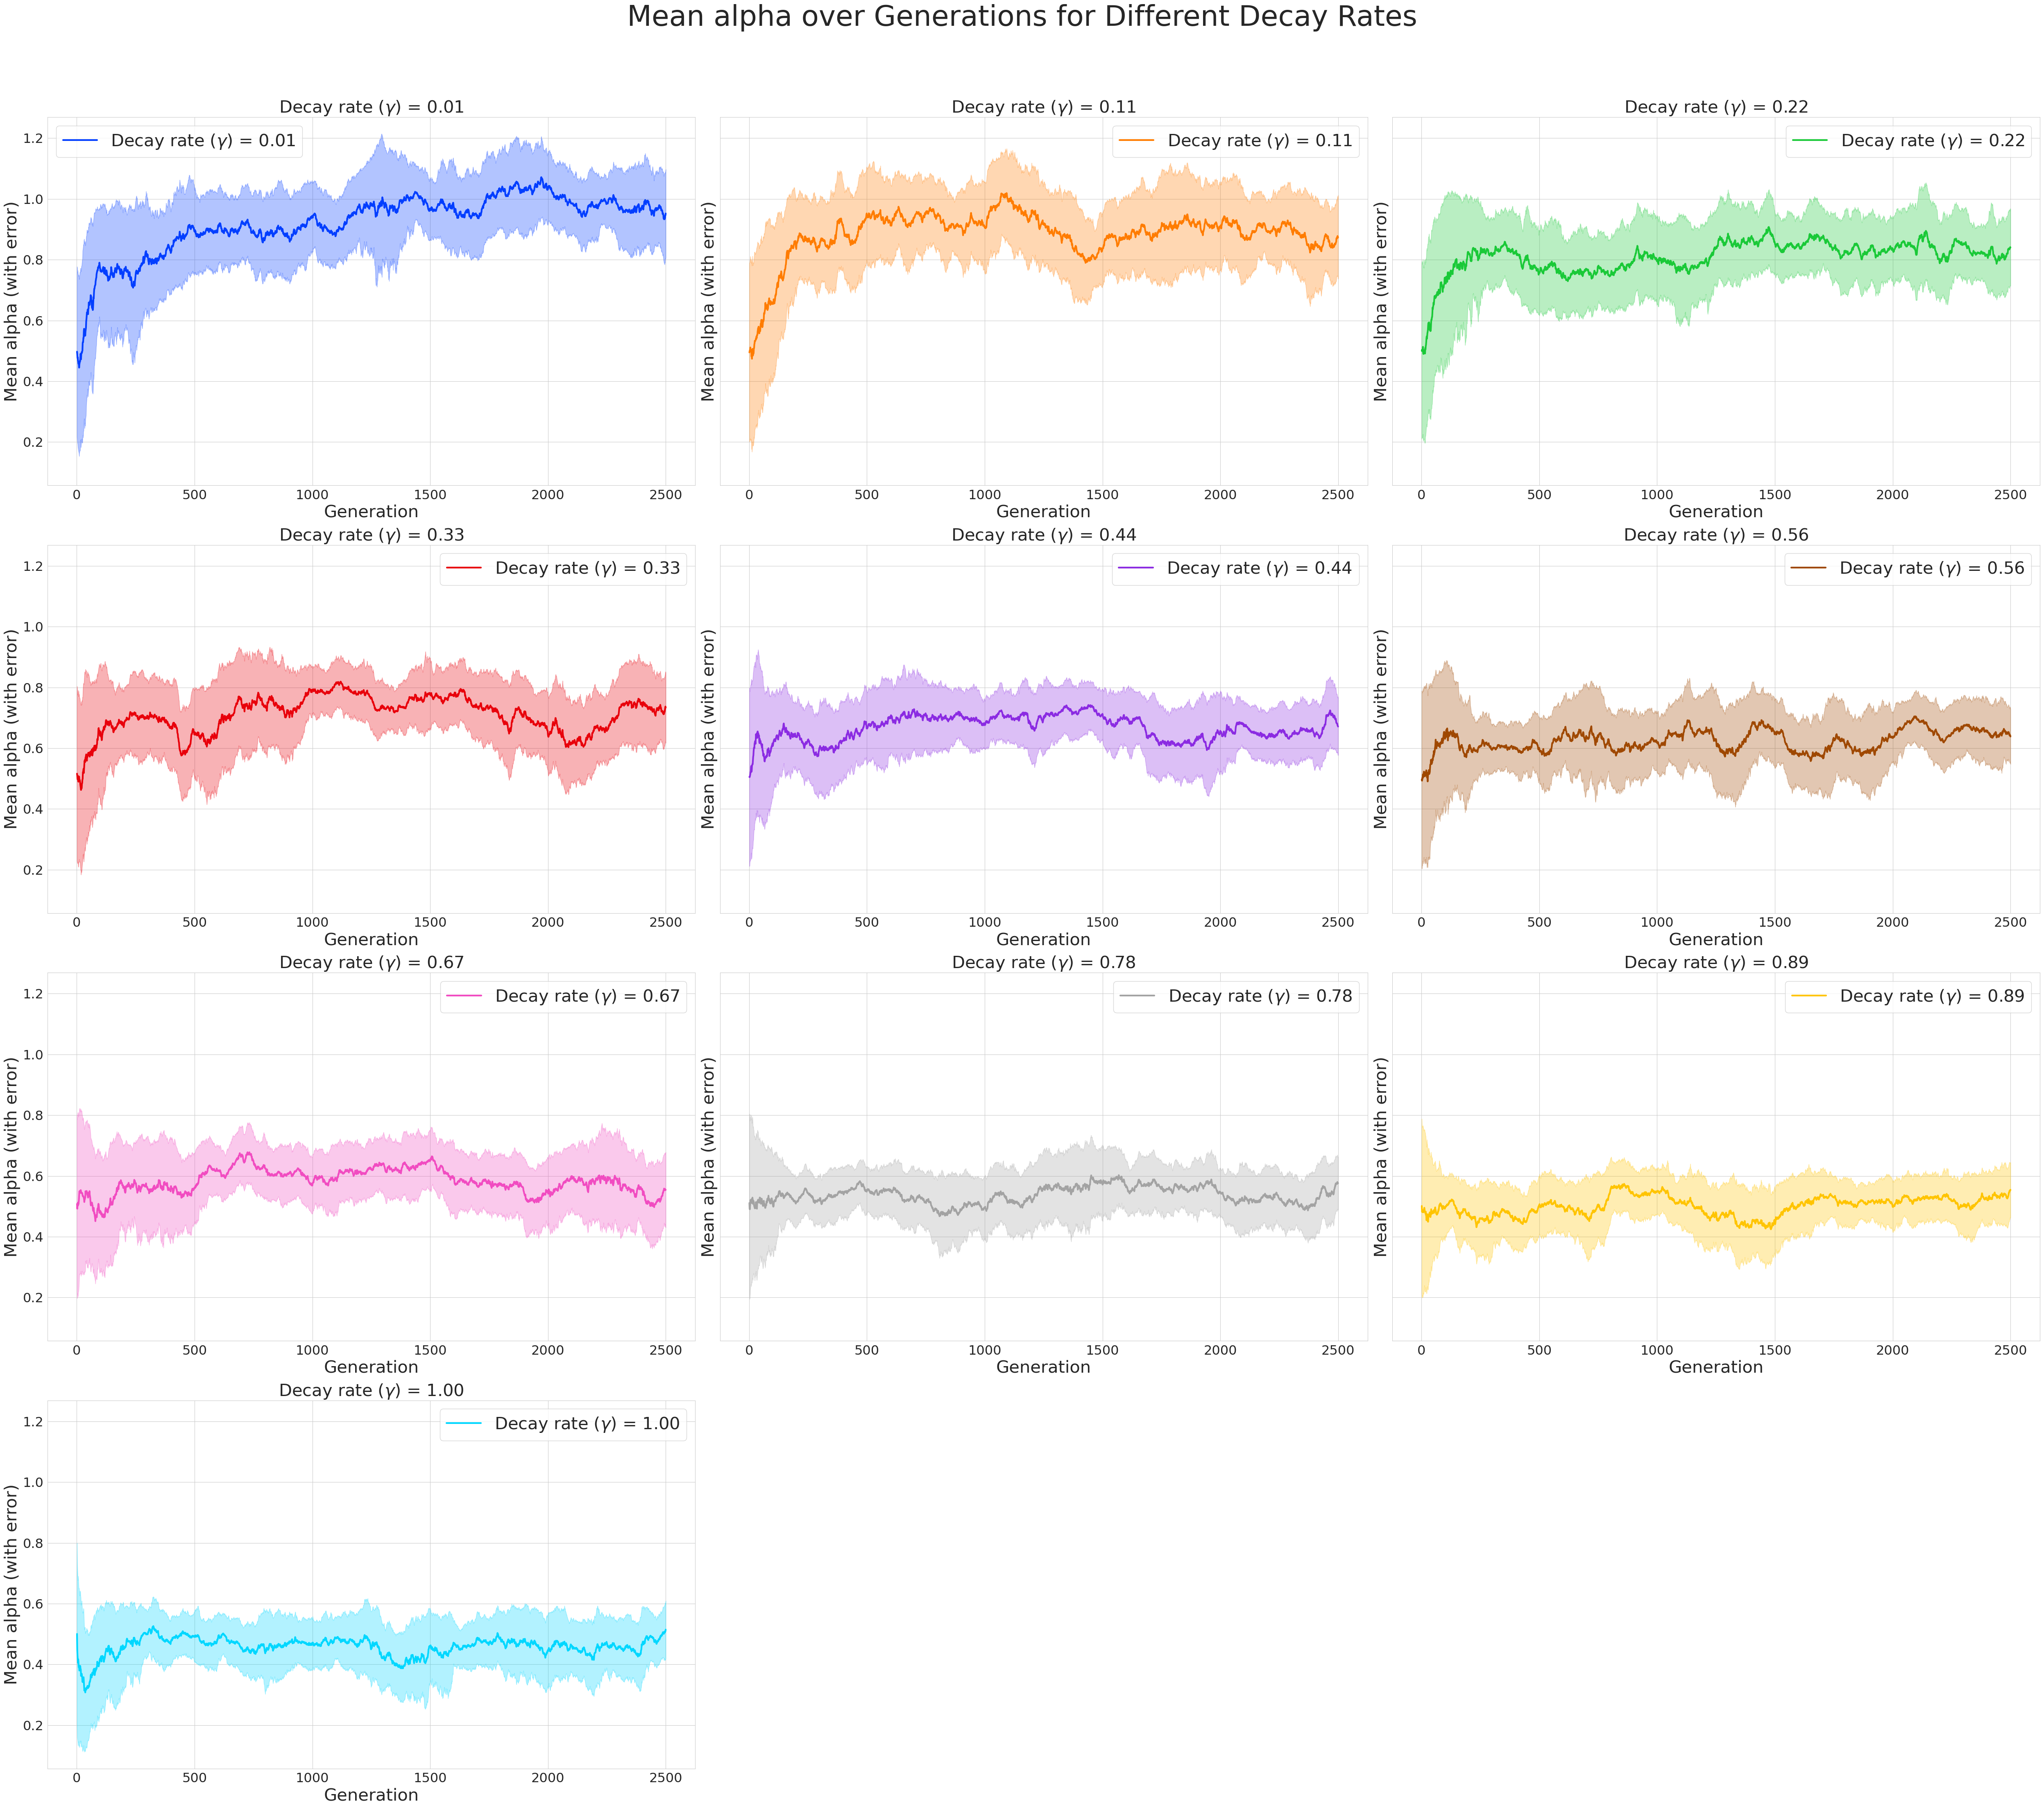

In [224]:

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
qual_palette = sns.color_palette("bright", len(results))
generations, results_df['Mean_alpha_werror']
# Create subplots: one row, n_panels columns
n_panels = len(results)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (50,45),sharey=True)


for ax, (i, gamma) in zip(axes, enumerate(results)):
    generations = resequilibrium_gamma_meansults[gamma]['Generation']
    y = results[gamma]['Mean_alpha_werror']
    error = results[gamma]['Std_alpha_werror']
    
    ax.plot(generations, y, label=f'Decay rate ($\\gamma$) = {gamma:.2f}', linewidth=3, color=qual_palette[i])
    ax.fill_between(generations, y - error, y + error, alpha=0.3, color=qual_palette[i])
    ax.set_xlabel('Generation', fontsize=30)
    ax.set_ylabel('Mean alpha (with error)', fontsize=30)
    ax.set_title(f'Decay rate ($\\gamma$) = {gamma:.2f}', fontsize=30)
    ax.legend(fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=23)
    
axes[10].axis('off')  
axes[11].axis('off')  
plt.suptitle('Mean alpha over Gene(rations for Different Decay Rates', fontsize=50)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Varying staying probablity

In [683]:

sp_values = np.linspace(0.8, 1, 100)
equilibrium_alpha_means_varsp = []
equilibrium_alpha_std_varsp=[]

# Select 10 indices from 0 to 99 to save trajectories for
selected_indices = np.linspace(0, 99, 10, dtype=int)
selected_sp_values = sp_values[selected_indices]

# To store mean gamma trajectories for selected sp values
alpha_trajectories = {sp: [] for sp in selected_sp_values}
results_sp = {}
alpha_trajectories

{np.float64(0.8): [],
 np.float64(0.8222222222222223): [],
 np.float64(0.8444444444444444): [],
 np.float64(0.8666666666666667): [],
 np.float64(0.888888888888889): [],
 np.float64(0.9111111111111111): [],
 np.float64(0.9333333333333333): [],
 np.float64(0.9555555555555556): [],
 np.float64(0.9777777777777777): [],
 np.float64(1.0): []}

In [684]:
for sp in sp_values:
    
        Transition_probs = np.array([
            [sp, 1-sp],
            [1-sp, sp]
        ])
    
        current_state = 0
        current_env = Env[current_state]
        
        # Initial population
        alpha = np.random.uniform(0, 1, population_size)
        z_a_t = np.random.uniform(-0.1, 0.1, population_size)
        epsilon_mut = np.random.normal(0, sigma_mut, size=population_size)
        epsilon_mat = np.random.normal(0, sigma_mat, size=population_size)
        epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
        z_a_t_mut = z_a_t + epsilon_mut
        P = np.random.uniform(-1, 1, size=population_size) # phenotype from the previous generation
    
        delta = P - z_a_t
        delta_error = (gamma*delta) + epsilon_mat
        alpha_error = alpha + epsilon_alpha
    
        P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error
    
        mean_alpha_over_time = []  # Initialize
        results_df = pd.DataFrame()
        
        for t in range(1, n_gen + 1):
            current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
            current_env = Env[current_state]
            
            P_com = z_dist(P, current_env)
            fitness = w(P_com)
            relative_fitness = fitness / fitness.mean()
            
            df = pd.DataFrame({
                'gen_plus_mut': z_a_t_mut,
                'Phenotype': P,
                'maternal_deviation_werror': delta_error,
                'alpha_w_error': alpha_error,
                'fitness': fitness,
                'relative_fitness': relative_fitness
            })
    
            gen_stats = {
                'Generation': t,
                'Environment': current_env,
                'Mean_fitness': df['fitness'].mean(),
                'Var_fitness': df['fitness'].var(),
                'Mean_phenotype': df['Phenotype'].mean(),
                'Std_phenotype': df['Phenotype'].std(),
                'Mean_gen_plus_mut': df['gen_plus_mut'].mean(),
                'Std_gen_plus_mut': df['gen_plus_mut'].std(),
                'Mean_maternal_deviation_werror': df['maternal_deviation_werror'].mean(),
                'Std_maternal_deviation_werror': df['maternal_deviation_werror'].std(),
                'Mean_alpha_werror': df['alpha_w_error'].mean(),
                'Std_alpha_werror': df['alpha_w_error'].std()
            }
    
            results_df = pd.concat([results_df, pd.DataFrame([gen_stats])], ignore_index=True)
    
            # Fitness-proportional sampling
            sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)
            z_a_t_mut = sampled_df['gen_plus_mut'].values
            P = sampled_df['Phenotype'].values
            alpha_error = sampled_df['alpha_w_error'].values
    

            # Mutation
            epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
            epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
            epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
            delta = P - z_a_t_mut
            z_a_t_mut = z_a_t_mut + epsilon_m
            delta_error = (gamma*delta) + epsilon_p # delta with decay rate multiplied
            alpha_error = alpha_error + epsilon_alpha
            alpha_error = np.clip(alpha_error, 0,1)
            P =  (1-alpha_error)*z_a_t_mut + alpha_error * delta_error
    
        # Save equilibrium stats
        equilibrium_mean_alpha = np.mean(alpha_error)
        equilibrium_std_alpha = np.std(alpha_error)
        equilibrium_alpha_means_varsp.append(equilibrium_mean_alpha)
        equilibrium_alpha_std_varsp.append(equilibrium_std_alpha)
    
        if sp in selected_sp_values:
            # Save full results_df for this gamma
            results_sp[sp]= results_df



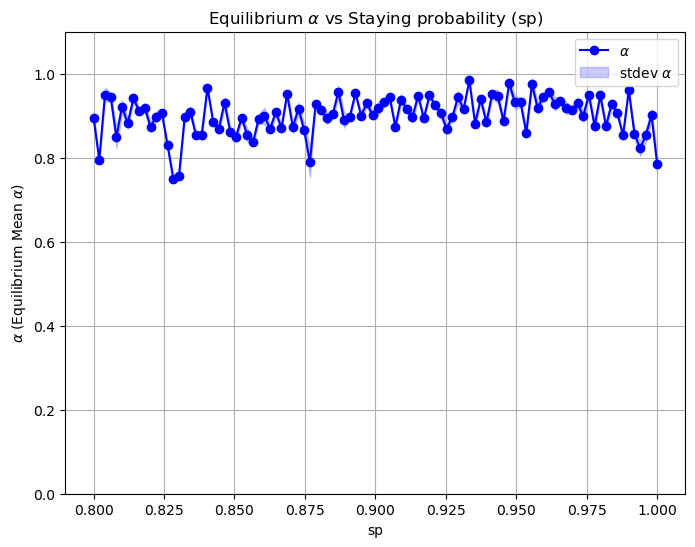

In [686]:
plt.figure(figsize=(8,6))

# Plotting the main line
plt.plot(sp_values, equilibrium_alpha_means_varsp, 'o-', color='b', label=r'$\alpha$')

# Creating the error cloud using fill_between
plt.fill_between(sp_values, 
                 np.array(equilibrium_alpha_means_varsp) - np.array(equilibrium_alpha_std_varsp), 
                 np.array(equilibrium_alpha_means_varsp) + np.array(equilibrium_alpha_std_varsp), 
                 color='b', alpha=0.2, label=r'stdev $\alpha$ ')

# Using LaTeX formatting for Greek letters
plt.xlabel('sp')
plt.ylabel(r'$\alpha$ (Equilibrium Mean $\alpha$)')
plt.title(r'Equilibrium $\alpha$ vs Staying probability (sp)')
plt.grid(True)
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Heat map across both params

In [416]:

sp_values = np.linspace(0, 1, 100)
equilibrium_gamma_means = []
eqm_gamma_std=[]

# Select 10 indices from 0 to 99 to save trajectories for
selected_indices = np.linspace(0, 99, 10, dtype=int)
selected_sp_values = sp_values[selected_indices]

# To store mean gamma trajectories for selected sp values
gamma_trajectories = {sp: [] for sp in selected_sp_values}


In [417]:
sp_values = np.linspace(0, 1, 100)

# Select 10 indices from 0 to 99 to save trajectories for
selected_indices = np.linspace(1, 99, 10, dtype=int)
selected_sp_values = sp_values[selected_indices]
selected_sp_values

array([0.01010101, 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [418]:
results_gamma_sp = []
results_selected_trajectories = {}

In [ ]:
for sp in sp_values:
    
    Transition_probs = np.array([
        [sp, 1-sp],
        [1-sp, sp]
    ])
    
    for gamma in gamma_values:
    
        current_state = 0
        current_env = Env[current_state]
        
        # Initial population
        alpha = np.random.uniform(0, 1, population_size)
        z_a_t = np.random.uniform(-0.1, 0.1, population_size)
        epsilon_mut = np.random.normal(0, sigma_mut, size=population_size)
        epsilon_mat = np.random.normal(0, sigma_mat, size=population_size)
        epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
        z_a_t_mut = z_a_t + epsilon_mut
        P = np.random.uniform(-10, 10, size=population_size)
        delta = P - z_a_t
        delta_error = (gamma*delta) + epsilon_mat
        alpha_error = alpha + epsilon_alpha
    
        P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error
    
        mean_alpha_over_time = []  # Initialize
        results_df = pd.DataFrame()
        
        for t in range(1, n_gen + 1):
            current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
            current_env = Env[current_state]
            
            P_com = z_dist(P, current_env)
            fitness = w(P_com)
            relative_fitness = fitness / fitness.mean()
            
            df = pd.DataFrame({
                'gen_plus_mut': z_a_t_mut,
                'Phenotype': P,
                'maternal_deviation_werror': delta_error,
                'alpha_w_error': alpha_error,
                'fitness': fitness,
                'relative_fitness': relative_fitness})
    
            gen_stats = {
                'Generation': t,
                'Environment': current_env,
                'Mean_fitness': df['fitness'].mean(),
                'Var_fitness': df['fitness'].var(),
                'Mean_resultsphenotype': df['Phenotype'].mean(),
                'Std_phenotype': df['Phenotype'].std(),
                'Mean_gen_plus_mut': df['gen_plus_mut'].mean(),
                'Std_gen_plus_mut': df['gen_plus_mut'].std(),
                'Mean_maternal_deviation_werror': df['maternal_deviation_werror'].mean(),
                'Std_maternal_deviation_werror': df['maternal_deviation_werror'].std(),
                'Mean_alpha_werror': df['alpha_w_error'].mean(),
                'Std_alpha_werror': df['alpha_w_error'].std()
            }
    
            results_df = pd.concat([results_df, pd.DataFrame([gen_stats])], ignore_index=True)
    
            # Fitness-proportional sampling
            sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)
            z_a_t_mut = sampled_df['gen_plus_mut'].values
            P = sampled_df['Phenotype'].values
            alpha_error = sampled_df['alpha_w_error'].values
    
            # Mutation
            epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
            epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
            epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
            delta = P - z_a_t_mut
            z_a_t_mut = z_a_t_mut + epsilon_m
            delta_error = (gamma*delta) + epsilon_p # delta with decay rate multiplied
            alpha_error = alpha_error + epsilon_alpha
            alpha_error = np.clip(alpha_error, 0,1)
            P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error
    
        # Save equilibrium stats
        equilibrium_mean_alpha = np.mean(alpha_error)
        equilibrium_std_alpha = np.std(alpha_error)
        
        results_gamma_sp.append({
            'Staying_prob': sp,
            'Gamma': gamma,
            'Alpha': equilibrium_mean_alpha,
            'Alpha_stdev':equilibrium_std_alpha}) 
        
        if (gamma, sp) in list(zip(selected_gamma_values, selected_sp_values)):
            results_selected_trajectories[gamma, sp] = results_df



In [ ]:
with open('/home/usriniva/Documents/weights_evolving/results_gamma_sp.pkl', 'wb') as f:  # open a text file
    pickle.dump(results_gamma_sp, f) # serialize the list
    
with open('/home/usriniva/Documents/weights_evolving/results_selected_trajectories.pkl', 'wb') as f:  # open a text file
    pickle.dump(results_selected_trajectories, f) # serialize the list

In [ ]:
results_gamma_sp_df=pd.DataFrame(results_gamma_sp)

In [ ]:

gamma_values = results_gamma_sp_df['Gamma']
alpha_values = results_gamma_sp_df['Alpha']

plt.figure(figsize=(8,6))
plt.scatter(gamma_values, alpha_values, c='blue', alpha=0.7, edgecolors='w', s=80)

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\alpha$')
plt.title('Scatter plot of Equilibrium α against γ')
plt.grid(True)
plt.tight_layout()
plt.show()

gamma_values = results_gamma_sp_df['Staying_prob']
alpha_values = results_gamma_sp_df['Alpha']

plt.figure(figsize=(8,6))
plt.scatter(gamma_values, alpha_values, c='blue', alpha=0.7, edgecolors='w', s=80)

plt.xlabel('Staying_prob')
plt.ylabel(r'$\alpha$')
plt.title('Scatter plot of Equilibrium α against γ')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
results_gamma_sp_pivoted_df=results_gamma_sp_df.pivot_table(
        index='Gamma',       # y-axis
        columns='Staying_prob',     # x-axis
        values='Alpha'
    ).sort_index().sort_index(axis=1)

results_gamma_sp_pivoted_df.head()

In [ ]:

plt.figure(figsize=(10, 6))
    
# Create contour plot
X =  sp_values

Y =  gamma_values

Z =  results_gamma_sp_pivoted_df.values

title = f'Equilibrum $\\alpha$ against $\\gamma$ and staying probability'
# Create meshgrid
X_mesh, Y_mesh = np.meshgrid(X, Y)
    
contour = plt.contourf(X_mesh, Y_mesh, Z, cmap='viridis')

plt.colorbar(contour)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('staying probability')
plt.ylabel(f'$\\gamma$')
plt.title(title)
plt.tight_layout()
plt.show()
    

In [ ]:

gamma_values = np.linspace(0, 0.001, 100)
equilibrium_alpha_means = []
eqm_gamma_std=[]

# Select 10 indices from 0 to 99 to save trajectories for
selected_indices = np.linspace(1, 99, 10, dtype=int)
selected_gamma_values = gamma_values[selected_indices]

# To store mean gamma trajectories for selected sp values
gamma_trajectories = {g: [] for g in selected_gamma_values}
gamma_trajectories

In [ ]:
results_gamma_sp = []
results_selected_trajectories = {}

In [ ]:
for sp in sp_values:
    
    Transition_probs = np.array([
        [sp, 1-sp],
        [1-sp, sp]
    ])
    
    for gamma in gamma_values:
    
        current_state = 0
        current_env = Env[current_state]
        
        # Initial population
        alpha = np.random.uniform(0, 1, population_size)
        z_a_t = np.random.uniform(-0.1, 0.1, population_size)
        epsilon_mut = np.random.normal(0, sigma_mut, size=population_size)
        epsilon_mat = np.random.normal(0, sigma_mat, size=population_size)
        epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
        z_a_t_mut = z_a_t + epsilon_mut
        P = np.random.uniform(-10, 10, size=population_size)
        delta = P - z_a_t
        delta_error = (gamma*delta) + epsilon_mat
        alpha_error = alpha + epsilon_alpha
    
        P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error
    
        mean_alpha_over_time = []  # Initialize
        results_df = pd.DataFrame()
        
        for t in range(1, n_gen + 1):
            current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
            current_env = Env[current_state]
            
            P_com = z_dist(P, current_env)
            fitness = w(P_com)
            relative_fitness = fitness / fitness.mean()
            
            df = pd.DataFrame({
                'gen_plus_mut': z_a_t_mut,
                'Phenotype': P,
                'maternal_deviation_werror': delta_error,
                'alpha_w_error': alpha_error,
                'fitness': fitness,
                'relative_fitness': relative_fitness})
    
            gen_stats = {
                'Generation': t,
                'Environment': current_env,
                'Mean_fitness': df['fitness'].mean(),
                'Var_fitness': df['fitness'].var(),
                'Mean_resultsphenotype': df['Phenotype'].mean(),
                'Std_phenotype': df['Phenotype'].std(),
                'Mean_gen_plus_mut': df['gen_plus_mut'].mean(),
                'Std_gen_plus_mut': df['gen_plus_mut'].std(),
                'Mean_maternal_deviation_werror': df['maternal_deviation_werror'].mean(),
                'Std_maternal_deviation_werror': df['maternal_deviation_werror'].std(),
                'Mean_alpha_werror': df['alpha_w_error'].mean(),
                'Std_alpha_werror': df['alpha_w_error'].std()
            }
    
            results_df = pd.concat([results_df, pd.DataFrame([gen_stats])], ignore_index=True)
    
            # Fitness-proportional sampling
            sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)
            z_a_t_mut = sampled_df['gen_plus_mut'].values
            P = sampled_df['Phenotype'].values
            alpha_error = sampled_df['alpha_w_error'].values
    
            # Mutation
            epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
            epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
            epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)
    
            delta = P - z_a_t_mut
            z_a_t_mut = z_a_t_mut + epsilon_m
            delta_error = (gamma*delta) + epsilon_p # delta with decay rate multiplied
            alpha_error = alpha_error + epsilon_alpha
            alpha_error = np.clip(alpha_error, 0,1)
            P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error
    
        # Save equilibrium stats
        equilibrium_mean_alpha = np.mean(alpha_error)
        equilibrium_std_alpha = np.std(alpha_error)
        
        results_gamma_sp.append({
            'Staying_prob': sp,
            'Gamma': gamma,
            'Alpha': equilibrium_mean_alpha,
            'Alpha_stdev':equilibrium_std_alpha}) 
        
        if (gamma, sp) in list(zip(selected_gamma_values, selected_sp_values)):
            results_selected_trajectories[gamma, sp] = results_df


In [298]:

def w(z_combined):
    return (np.exp(-z_combined**2 /(100))) 

def z_dist(z1, env_opt):
    x0 = env_opt
    return ((np.sqrt((x0 - z1)**2 )))

# Define states
states = ["Dry", "Wet"]

sp =0.995 #staying probability

# Transition probability matrix
Transition_probs = np.array([
    [sp, (1-sp)],  # From Dry
    [(1-sp), sp]   # From Wet
])
# Simulate environment over time
n_gen =  2500

#baseline maternal effect
population_size= 1000

env_sequence = []
current_state = 0 

Env = np.array([
    -5,  
    12  
 ])

gamma=1
sigma_alpha=0.001

In [384]:

def run_simulation(args):
    sigma_mut, sigma_alpha, sigma_mat, n_gen, population_size, gamma, sp, Env = args
    # Transition probability matrix
    Transition_probs = np.array([
        [sp, (1-sp)],  # From Dry
        [(1-sp), sp]  ]) # From Wet
    
    
    current_state = 0
    current_env = Env[current_state]

    # Initialize population
    alpha = np.random.uniform(0, 1, population_size)
    z_a_t = np.random.uniform(-0.1, 0.1, population_size)
    epsilon_mut = np.random.normal(0, sigma_mut, size=population_size)
    epsilon_mat = np.random.normal(0, sigma_mat, size=population_size)
    epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)

    z_a_t_mut = z_a_t + epsilon_mut
    P = np.random.uniform(-10, 10, size=population_size)
    delta = P - z_a_t
    delta_error = (gamma * delta) + epsilon_mat
    alpha_error = alpha + epsilon_alpha
    P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error

    # Initialize results storage
    results_df = pd.DataFrame()

    for t in range(1, n_gen + 1):
        current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
        current_env = Env[current_state]

        P_com = z_dist(P, current_env)
        fitness = w(P_com)
        relative_fitness = fitness / fitness.mean()

        df = pd.DataFrame({
            'gen_plus_mut': z_a_t_mut,
            'Phenotype': P,
            'maternal_deviation_werror': delta_error,
            'alpha_w_error': alpha_error,
            'fitness': fitness,
            'relative_fitness': relative_fitness
        })

        gen_stats = {
            'Generation': t,
            'Environment': current_env,
            'Mean_fitness': df['fitness'].mean(),
            'Var_fitness': df['fitness'].var(),
            'Mean_resultsphenotype': df['Phenotype'].mean(),
            'Std_phenotype': df['Phenotype'].std(),
            'Mean_gen_plus_mut': df['gen_plus_mut'].mean(),
            'Std_gen_plus_mut': df['gen_plus_mut'].std(),
            'Mean_maternal_deviation_werror': df['maternal_deviation_werror'].mean(),
            'Std_maternal_deviation_werror': df['maternal_deviation_werror'].std(),
            'Mean_alpha_werror': df['alpha_w_error'].mean(),
            'Std_alpha_werror': df['alpha_w_error'].std()
        }

        results_df = pd.concat([results_df, pd.DataFrame([gen_stats])], ignore_index=True)

        # Fitness-proportional sampling
        sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)
        z_a_t_mut = sampled_df['gen_plus_mut'].values
        P = sampled_df['Phenotype'].values
        alpha_error = sampled_df['alpha_w_error'].values

        # Mutation
        epsilon_m = np.random.normal(0, sigma_mut, size=population_size)
        epsilon_p = np.random.normal(0, sigma_mat, size=population_size)
        epsilon_alpha = np.random.normal(0, sigma_alpha, size=population_size)

        delta = P - z_a_t_mut
        z_a_t_mut = z_a_t_mut + epsilon_m
        delta_error = (gamma * delta) + epsilon_p
        alpha_error = alpha_error + epsilon_alpha
        alpha_error = np.clip(alpha_error, 0, 1)
        P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error

    # Final equilibrium stats
    equilibrium_mean_alpha = np.mean(alpha_error)
    equilibrium_std_alpha = np.std(alpha_error)

    return {
        'sp': sp ,
        'gamma': gamma,
        'Alpha': equilibrium_mean_alpha,
        'Alpha_stdev': equilibrium_std_alpha
    }

